# rl5E_lite.ipynb

This notebook contains the fifth step in the 5-step process outlined in November 13th, 2020, in order to produce an actor-critic architecture for pendulum control. 

In step 1 we create a network with N units that takes the activity of 1 unit and transforms it into a bell-shaped representation.  
In step 2 we put 2 of those as the inputs to a (N/2)x(N/2) grid, and visualized.  
In step 3 we took the network from step 2 and connected it to the current SP and SD units in `test3p2` to see if the angle is being tracked.  
In step 4 we will connect a $V$ neuron to the L (RBF) layer, and tweak TD learning so its output starts to reflect the angular error.  
In step 5 the output of $V$ is used to configure a controller. There are three basic options outlined in the November 20th, 2020 entry of the log, and a fourth option in Nov. 30th. This fifth option was introduced in December 1st, 2020.

In this "lite" version the L layer, and the L__V, L__X synapses are substituded by two multidimensional units (see Jan 4, 2021 log).

In [1]:
%cd ../..
from draculab import *
import numpy as np
import matplotlib.pyplot as plt
import time
from tools.visualization import plotter

/home/z/projects/draculab/notebook


In [2]:
#===================================================================
#================ CREATE THE NETWORK ===============================
#===================================================================

#np.random.seed(123456) # always the same random values
np.random.seed()   # different random values ever run

# some parameters 
C_type = "rga_sig" # unit type for the C population
X_type = unit_types.x_netB
des_angs = np.pi*(-1. + 2.*np.random.random(10000))
#des_sf = 0.05 + 0.8*np.random.random(10000) # list of "predicted" SF values| set below now
pres_interv = 5. # interval that desired values last
par_heter = 0.1 # range of heterogeneity as a fraction of the original value
randz = lambda : (1. + par_heter*(np.random.rand()-0.5))
randz2 = lambda : (1. + par_heter*(np.random.rand(2)-0.5))
randz4 = lambda : (1. + par_heter*(np.random.rand(4)-0.5))
SN = 20 # number of units to represent one angle
No2 = int(np.ceil(SN/2)) # L wiill have (No2)**2 units

# PARAMETER DICTIONARIES
net_params = {'min_delay' : 0.005,
              'min_buff_size' : 8 }
#--------------------------------------------------------------------
# Unit parameters
#--------------------------------------------------------------------
A_params = {'type' : unit_types.logarithmic,
            'init_val' : 0.,
            'tau' : 0.01, # 0.02
            'tau_fast': 0.005,
            'thresh' : 0. } #[0.1, 0.1, 0.1, 0.1] } 
if C_type == "am_pm":
    init_base = np.array([0.5, 0.5, 2.*np.pi, 0.5])
    C_unit_type = unit_types.am_pm_oscillator
elif C_type == "am2D":
    init_base = np.array([0.5, 0.5])
    C_unit_type = unit_types.am_oscillator2D
elif C_type == "am_pulse":
    init_base = np.array([0.5, 0.5])
    C_unit_type = unit_types.am_pulse
elif C_type == "am":
    init_base = np.array([0.5, 0.5, 0.5])
    C_unit_type = unit_types.am_oscillator
elif C_type == "rga_sig":
    init_base = np.array([0.5])
    C_unit_type = unit_types.rga_sig
C_params = {'type' : C_unit_type, #unit_types.am_pm_oscillator,
            'integ_meth' : 'euler_maru', #'euler_maru', #'odeint',
            'tau_u' : 0.5 * randz2(), # 0.4*randz2()
            'tau_c' : 0.1 * randz2(), # 0.2
            'tau_t' : 1.,
            'tau_s' : 0.02,
            #'delay' : 0.35,
            'init_val' : [r*init_base for r in np.random.random(2)],
            'multidim' : False if C_type=="rga_sig" else True,
            'omega' : 2.*np.pi,
            'F' : 'zero', #'input_sum',
            'A' : 0.5,
            'slope' : 2., # for rga_sig
            'thresh' : 0.2, # for rga_sig
            'integ_amp' : 0., # for rga_sig
            'tau' : 0.02, # for rga_sig
            'tau_fast': 0.01, #0.02,
            'tau_mid' : 0.05, #0.1,
            'tau_slow' : 3.,
            'custom_inp_del' : 150,
            'delay' : 0.31,
            'mu' : 0.,
            'sigma' : 0.4 }
# desired angle in the (0, 2*pi) range
da = np.array([a if a > 0. else 2.*np.pi + a for a in des_angs])
DA_params = {'type' : unit_types.source,
             'init_val' : da[0],
             'function' : lambda t: da[int(np.floor(t/pres_interv))] }
# L is the "RBF" layer to represent S_P, S_F
# L_params = {'type' : unit_types.sigmoidal,
#             'delay' : .3,
#             'thresh' : 2.,
#             'slope' : 5.,
#             'tau' : 0.02,
#             'init_val' : 0.5 }
# L_geom = {'shape' : 'sheet',
#           'arrangement' : 'grid',
#           'rows' : No2,
#           'columns' : No2,
#           'center' : [0., 0.],
#           'extent' : [1., 1.] }

M_params = {'type' : unit_types.m_sig,
            'thresh' : 0.5 * randz2(),
            'slope' : 2.5 * randz2(),
            'init_val' : 0.2 * randz2(),
            'delay' : 0.35,
            'n_ports' : 4,
            'tau_fast': 0.01, #0.2, #0.01,
            'tau_mid': 0.05, #1., #0.05,
            'tau_slow' : 8.,
            'tau' : 0.01 * randz2(),
            'coordinates' : [np.array([0.1, 0.8]), np.array([0.4, 0.8])],
            'integ_amp' : 0.,
            'custom_inp_del' : int(np.round(0.3/net_params['min_delay'])) ,
            'des_out_w_abs_sum' : 1.6 }
MPLEX_params = {'type' : unit_types.linear_mplex,
                'init_val' : 0.,
                'delay' : 0.5,
                'tau' : 0.01 }
# plant parameters
P_params = {'type' : plant_models.pendulum, #bouncy_pendulum,
            'length' : 0.5,
            'mass' : 1.,
            'init_angle' : 0.,
            'init_ang_vel' : 0.,
            'g' : 9.81,
            'inp_gain' : 4., #2.,
            'mu' : 1.,
            'delay' : None, # set after V_params
            'bound_angle' : True,
            'pi_visco' : 0.05,
            'tau' : 0.05 } # a made-up time constant for the plant 
                          # see create_freqs_steps below
# Reward unit parameters
R_params = {'type' : unit_types.source,
            'function' : lambda t: None, # to be set below
            'coordinates' : np.array([.3, .8]),
            'init_val' : 0.3 }
# S1 and S2 provide the distributed angle representations
# S_params = {'type' : unit_types.bell_shaped_1D,
#             'init_val' : 0.1,
#             'tau' : 0.01,
#             'center' : list(np.linspace(0., 1., SN)),
#             'b' : 50. }
# S1_params = S_params.copy() # the input column on the left
# S2_params = S_params.copy() # the input row below
# S1_params['coordinates'] = [np.array([-.6, -.5 + i/SN]) for i in range(SN)]
# S2_params['coordinates'] = [np.array([-.5 + i/SN, -.6]) for i in range(SN)]
# SF, SP
SF_params = {'type' : unit_types.sigmoidal,
             'thresh' : 0.,
             'slope' : 1.5,
             'init_val' : 0.2,
             'tau' : 0.02 }  # 0.05
## The desired values for SF
des_sf = 1./(1. + np.exp(-SF_params['slope']*(des_angs - SF_params['thresh'])))

SP_params = {'type' : unit_types.source,
             'init_val' : des_sf[0],
             'tau_fast' : 0.01,
             'tau_mid' : 0.2,
             'function' : lambda t: des_sf[int(np.floor(t/pres_interv))] }
# 1-D error units
SPF_params = {'type' : unit_types.sigmoidal,
              'thresh' : 0.5 * randz2(),
              'slope' : 5. * randz2(),
              'init_val' : 0.3 * randz2(),
              'tau_fast': 0.005,
              'tau_mid': 0.05,
              'tau_slow' : 5.,
              'tau' : 0.02 * randz2() }
# Angle transformation unit
T_params = {'type' : unit_types.source,
            'init_val' : des_sf[0],
            'function' : lambda t: None } # to be set after unit creation
# value unit
V_params = {'type' : unit_types.v_net,
            'multidim' : True,
            'delay' : .5,
            'init_val' : [0.1]*101,
            'thresh' : 0.,
            'slope' : 1.5,
            'L_wid' : .5 * No2 / np.pi,
            #'R_wid' : 2.,
            'tau' : 0.02,
            'tau_slow': 50.,
            'delta' : 1.,
            'td_lrate' : 1.,
            'td_gamma' : 0.6,
            'normalize' : True,
            'w_sum' : 40.,
            'coordinates' : np.array([.8, .8])}
P_params['delay'] = V_params['delta'] + net_params['min_delay']
# The configurator unit
X_params = {'type' : X_type,
            'multidim' : True,
            'init_val' : np.concatenate((np.array([0.5]), 0.1*np.ones(100))),
            'tau' : 0.02,
            'slope' : 5.,
            'thresh' : 0.,
            'del_steps' : int(np.round(0.3/net_params['min_delay'])),
            'lrate' : 30., #200.,
            'L_wid' : .5 * No2 / np.pi,
            'delay' : 0.35,
            'tau_fast' : 0.05,
            'tau_mid' : 0.5,
            'tau_slow' : 50.,
            'sw_thresh' : 0.03,
            'sw_len' : 0.4,
            'switch' : True,
            'normalize' : True,
            'w_sum' : 40.,
            'refr_per' : 2.,
            'beta' : 2.,
            'r_thr' : np.pi/6.,
            'coordinates' : np.array([0.7, 0.3]) }
            
# units to track synaptic weights or other values
track_params = {'type' : unit_types.source,
                'init_val' : 0.02,
                'function' : lambda t: None }

#--------------------------------------------------------------------
# Connection dictionaries
#--------------------------------------------------------------------
# Afferent to motor error selection
A__M_conn = {'rule' : 'all_to_all',
             'delay' : 0.02 }
A__M_syn = {'type' : synapse_types.inp_sel, 
            'inp_ports' : 2, # the deault for m_sig targets
            'error_port' : 1, # the default for m_sig targets
            'aff_port' : 2,
            'lrate' : 5., # negative rate for m_sig targets with value inputs
            'w_sum' : .4,
            'w_max' : 0.3,
            'init_w' : .1 }
# lateral connections in C
C__C_conn = {'rule': 'one_to_one',
             'allow_autapses' : False,
             'delay' : 0.015 }
C__C_syn = {'type' : synapse_types.static,
            'lrate' : 0.1,
            'inp_ports': 1,
            'init_w' : -1.5 }  # Changed from usual -1
# spinal units to plant
C0__P_conn = {'inp_ports' : 0,
             'delays': 0.01 }
C0__P_syn = {'type': synapse_types.static,
            'init_w' : 2. }
C1__P_conn = C0__P_conn
C1__P_syn = {'type': synapse_types.static,
             'init_w' : -2. }
DA__VX_conn = {'rule' : 'one_to_one',
               'delay' : 0.01 }
DA__VX_syn = {'type' : synapse_types.static,
              'init_w' : 1.,
             'inp_ports' : 1 }
# expanded state to value unit
# L__V_conn = {'rule': 'all_to_all',
#             'delay': 0.02 }
# L__V_syn = {'type' : synapse_types.td_synapse,
#             'lrate': .05,
#             'gamma' : 0.6,
#             'inp_ports': 0,
#             'init_w' : 0.2 * np.random.random(No2*No2), # 0.05
#             'max_w' : 1.,
#             'w_sum' : 10. }
# state to configurator
# L__X_conn = {'rule': 'all_to_all',
#             'delay': 0.02 }
# L__X_syn = {'type' : synapse_types.diff_rm_hebbian,
#             'lrate': .2,
#             'inp_ports': 0, # default for x_sig, m_sig targets
#             #'l_port' : 3,
#             #'s_port' : 0,
#             #'v_port' : 1,
#             'init_w' : 0.2 * np.random.random(No2*No2),
#             'w_sum' : 10. }
# motor error to spinal
M__C_conn = {'rule': 'all_to_all',
             'delay': 0.02 }
M__C_syn = {'type' : synapse_types.rga_21,
            'lrate': 500., #50
            'inp_ports': 0,
            'w_sum' : 2.,
            'init_w' : {'distribution':'uniform', 'low':0.05, 'high':.1}}
# motor error lateral connections
M__M_conn = {'rule': 'one_to_one',
             'allow_autapses' : False,
             'delay' : 0.01 }
M__M_syn = {'type' : synapse_types.static,
            'lrate' : 0.1,
            'inp_ports': 3, # default for m_sig targets
            'init_w' : -1. }
# motor error to plant
# M0__P_conn = {'inp_ports' : 0,
#              'delays': 0.01 }
# M0__P_syn = {'type': synapse_types.static,
#             'init_w' : 2. }
# M1__P_conn = M0__P_conn
# M1__P_syn = {'type': synapse_types.static,
#              'init_w' : -2. }
# multiplexer to V, X
# MPLEX0__VX_conn = {'rule' : 'one_to_one',
#                   'delay' : 0.01}
# MPLEX0__VX_syn = {'type' : synapse_types.static,
#                   'init_w' : 1.,
#                   'inp_ports' : 0 }
# MPLEX1__VX_conn = {'rule' : 'one_to_one',
#                   'delay' : 0.01}
# MPLEX1__VX_syn = {'type' : synapse_types.static,
#                   'init_w' : 1.,
#                   'inp_ports' : 1 }
# multiplexer SP selection to X
# MPLEX1__X_conn = {'rule' : 'one_to_one',
#                   'delay' : 0.01}
# MPLEX1__X_syn = {'type' : synapse_types.static,
#                  'init_w' : 1.,
#                  'inp_ports' : 2 }
# plant to sensory/motor
P__A_conn = {'port_map' : [[(0,0)], [(1,0)], [(0,0)], [(1,0)]],
             'delays' : 0.02 }
P__A_syn = {'type' : synapse_types.static,
            'init_w' : [1., 1., -1., -1.] }
P__SF_conn = {'port_map' : [(0,0)],
              'delays' : 0.01 }
P__SF_syn = {'type' : synapse_types.static,
             'init_w' : 1. }
# plant to V,X
P__VX_conn = {'port_map' : [(0,0)],
              'delays' : 0.02 }
P__VX_syn = {'type' : synapse_types.static,
             'init_w' : 1. }
# reward to value unit
R__V_conn = {'rule' : 'one_to_one',
             'delay' : 0.01 }
R__V_syn = {'type' : synapse_types.static,
            'inp_ports' : 2,
            'init_w' : 1.}
# distributed angle to RBF layer
# S1__L_conn_spec = {'connection_type' : 'divergent',
#                   'mask' : {'circular' : {'radius' : 2. }},
#                   'kernel' : 1.,
#                   'delays' : {'linear' : {'c' : 0.01, 'a': 0.01}},
#                   'weights' : {'gaussian' : {'w_center' : 1.5, 'sigma' : 0.01}},
#                   'dist_dim' : 'y',
#                   'edge_wrap' : True,
#                   'boundary' : {'center' : [-0.05, 0.], 'extent':[1.1, 1.]} }
# S2__L_conn_spec = S1__L_conn_spec.copy()
# S2__L_conn_spec['dist_dim'] = 'x'
# S2__L_conn_spec['boundary'] = {'center' : [0., -0.05], 'extent':[1., 1.1]}
# S1__L_syn_spec = {'type' : synapse_types.static }
# S2__L_syn_spec = {'type' : synapse_types.static }
# distributed angle to layer distance (reward)
# S1__R_conn = {'rule': 'all_to_all',
#               'delay': 0.01 }
# S1__R_syn = {'type': synapse_types.static,
#              'inp_ports' : 0,
#              'init_w' : 1. }
# S2__R_conn = {'rule': 'all_to_all',
#               'delay': 0.01 }
# S2__R_syn = {'type': synapse_types.static,
#              'inp_ports' : 1,
#              'init_w' : 1. }
# SF rate representation to distributed representation
SF__S_conn = {'rule' : 'all_to_all',
             'delay' : 0.01 }
SF__S_syn = {'type' : synapse_types.static,
            'init_w' : 1. }
# SF/SP to multiplexer
SF__MPLEX_conn = {'rule' : 'all_to_all',
                  'delay' : 0.01 }
SF__MPLEX_syn = {'type' : synapse_types.static,
                 'inp_ports' : [0, 1],
                 'init_w' : 1. }
SP__MPLEX_conn = {'rule' : 'all_to_all',
                  'delay' : 0.01 }
SP__MPLEX_syn = {'type' : synapse_types.static,
                 'inp_ports' : [0, 1],
                 'init_w' : 1. }
# SF/SP to SPF
SFe__SPF_conn = {'rule' : "all_to_all",
                 'delay' : 0.01 }
SFi__SPF_conn = {'rule' : "all_to_all",
                 'delay' : 0.015 }
SFe__SPF_syn = {'type' : synapse_types.static,
                'init_w' : 1. }
SFi__SPF_syn = {'type' : synapse_types.static,
                'init_w' : -1. }
SPe__SPF_conn = {'rule' : "all_to_all",
                 'delay' : 0.01 }
SPi__SPF_conn = {'rule' : "all_to_all",
                 'delay' : 0.015 }
SPe__SPF_syn = {'type' : synapse_types.static,
                'init_w' : 1. }
SPi__SPF_syn = {'type' : synapse_types.static,
               'init_w' : -1. }
# SP rate representation to distributed representation
SP__S_conn = SF__S_conn
SP__S_syn = SF__S_syn
# SPF to M
SPF__M_conn = {'rule': 'one_to_one',
               'delay': 0.01 }
SPF__M_syn = {'type' : synapse_types.static,
              'inp_ports' : 1,
              'lrate' : 20.,
              'input_type' : 'error',
              'init_w' : 1. }
# rotated angle to SF[1]
T__SF_conn = {'rule': 'one_to_one',
             'delay': 0.01 }
T__SF_syn = {'type' : synapse_types.static,
            'inp_ports' : 0,
            'init_w' : P__SF_syn['init_w'] }
# Value to configurator
V__X_conn = {'rule': 'all_to_all',
             'delay': 0.01 }
V__X_syn = {'type' : synapse_types.static,
            'inp_ports' : 2,
            'init_w' : 1. }
# configurator to multiplexer
X__MPLEX_conn = {'rule': 'all_to_all',
                 'delay': 0.01 }
X__MPLEX_syn = {'type' : synapse_types.static,
                'inp_ports' : 2,
                'init_w' : 1. }

def create_freqs_steps(n, w, r):
    """ Returns a 2-tuple with the lists required for heterogeneous frequencies.
    
        We assume that the important loop for the learning rule in the C units
        is the one going through C-P-M-C
        Args:
            n : number of units
            w : base omega value (rad)
            r : amplitude of noise as fraction of original value
        Returns
            2-tuple : (freqs, steps)
            freqs : a list with n angular frequencies.
            steps : a list with the corresponding delays. 
    """
    ws = w * (1. + r*((np.random.random(n) - 0.5)))
    ws = ws / C_params['tau_t'] # angular frequencies
    cp_del = np.arctan(np.mean(P_params['tau'])*ws)/ws
    pm_del = np.arctan(np.mean(M_params['tau'])*ws)/ws
    am_del = np.arctan(np.mean(A_params['tau'])*ws)/ws
    D = [C0__P_conn['delays'], np.mean(P__A_conn['delays']), 
         A__M_conn['delay'], M__C_conn['delay'] ]
    d1 = cp_del + pm_del + am_del + sum(D)
    del_steps = [int(d) for d in np.ceil(d1/net_params['min_delay'])]
    return (list(ws), del_steps)

#--------------------------------------------------------------------
# CREATING UNITS
#--------------------------------------------------------------------
net = network(net_params)
topo = topology()

A = net.create(4, A_params)
# creating C with heterogeneous frequencies
omegas, del_steps = create_freqs_steps(2, C_params['omega'], par_heter)
C_params['omega'] = omegas
C_params['custom_inp_del'] = del_steps
C = net.create(2, C_params)
DA = net.create(1, DA_params)
#L = topo.create_group(net, L_geom, L_params)
M = net.create(2, M_params)
MPLEX = net.create(2, MPLEX_params)
P = net.create(1, P_params)
R = net.create(1, R_params)
#S1 = net.create(SN, S1_params)
#S2 = net.create(SN, S2_params)
SF = net.create(2, SF_params)
SP = net.create(2, SP_params)
SPF = net.create(2, SPF_params)
T = net.create(1, T_params)
V = net.create(1, V_params)
X = net.create(1, X_params)

# tracking units
M_C0_track = net.create(2, track_params) # to track weights from M to C0
A_M0_track = net.create(2, track_params) # to track weights from A to M0
xp_track = net.create(1, track_params) # del_avg_inp_deriv of C0 at port 1
up_track = net.create(1, track_params) # to track the derivative of C0
sp_track = net.create(1, track_params) # avg_inp_deriv_mp for C0 at port 0
spj_track = net.create(1, track_params) # input derivative for SPF0--C0
v_track = net.create(No2*No2, track_params) # L__V weights
x_track = net.create(No2*No2, track_params) # L__X weights

if C_type != "rga_sig":
    dc_track = net.create(2, track_params) # DC component of C units
    
# Configuring transformation unit
def t_fun(time):
    """ Pendulum angle after a \pi rads rotation of the coordinate system.
    
        Normally the bound angle for the pendulum is between -pi and pi. This
        function retrieves the pendulum angle in the 0, 2pi interval.
    
        Args:
            time : time at which the angle is retrieved
        Returns:
            1-D scalar with rotated angle.
    """
    x = net.plants[P].get_state_bound(time)[0]
    return x - np.pi if x < np.pi and x > 0 else np.pi + x
net.units[T[0]].set_function(t_fun)

# Configuring alternate desired angle unit
def alt_des_fun(time):
    """ The alternate desired SF value. """
    sd = des_sf[int(np.floor(time/pres_interv))]
    sd_inv = np.log(sd / (1.-sd))/SF_params['slope'] + SF_params['thresh']
    t = sd_inv - np.pi if sd_inv < np.pi and sd_inv > 0 else np.pi + sd_inv
    return 1. / ( 1. + np.exp(-SF_params['slope']*(t - SF_params['thresh'])) )
net.units[SP[1]].set_function(alt_des_fun)

# configuring reward unit
def r_fun(time):
    """ The reward value at a given time. """
    dang = da[int(np.floor(time/pres_interv))] # desired angle in [0, 2pi]
    cang = net.plants[P].get_angle(time) # angle in [0,2*pi] interval
    dist = min(abs(dang-cang), 2.*np.pi - max(dang,cang) + min(dang,cang))
    return np.exp(-dist*dist)
net.units[R[0]].set_function(r_fun)

#--------------------------------------------------------------------
# CONNECTING
#--------------------------------------------------------------------
net.connect([A[1],A[3]], M, A__M_conn, A__M_syn) # only velocity afferents
net.connect([C[0]], [C[1]], C__C_conn, C__C_syn)
net.connect([C[1]], [C[0]], C__C_conn, C__C_syn)
net.set_plant_inputs([C[0]], P, C0__P_conn, C0__P_syn)
net.set_plant_inputs([C[1]], P, C1__P_conn, C1__P_syn)
net.connect(DA, V, DA__VX_conn, DA__VX_syn)
net.connect(DA, X, DA__VX_conn, DA__VX_syn)
# net.connect(L, V, L__V_conn, L__V_syn)
# net.connect(L, X, L__X_conn, L__X_syn)
net.connect(M, C, M__C_conn, M__C_syn)
net.connect([M[0]], [M[1]], M__M_conn, M__M_syn)
net.connect([M[1]], [M[0]], M__M_conn, M__M_syn)

net.connect([MPLEX[0]], [SPF[0]], SFe__SPF_conn, SFe__SPF_syn)
net.connect([MPLEX[1]], [SPF[0]], SPi__SPF_conn, SPi__SPF_syn)
net.connect([MPLEX[0]], [SPF[1]], SFi__SPF_conn, SFi__SPF_syn)
net.connect([MPLEX[1]], [SPF[1]], SPe__SPF_conn, SPe__SPF_syn)

# net.connect([MPLEX[0]], V, MPLEX0__VX_conn, MPLEX0__VX_syn)
#net.connect([MPLEX[0]], X, MPLEX0__VX_conn, MPLEX0__VX_syn)
# net.connect([MPLEX[1]], V, MPLEX1__VX_conn, MPLEX1__VX_syn)
#net.connect([MPLEX[1]], X, MPLEX1__VX_conn, MPLEX1__VX_syn)

net.set_plant_outputs(P, [SF[0]], P__SF_conn, P__SF_syn)
net.set_plant_outputs(P, A, P__A_conn, P__A_syn) 
net.set_plant_outputs(P, V, P__VX_conn, P__VX_syn)
net.set_plant_outputs(P, X, P__VX_conn, P__VX_syn)
# topo.topo_connect(net, S1, L, S1__L_conn_spec, S1__L_syn_spec)
# topo.topo_connect(net, S2, L, S2__L_conn_spec, S2__L_syn_spec)
# net.connect(S1, R, S1__R_conn, S1__R_syn)
# net.connect(S2, R, S2__R_conn, S2__R_syn)
# net.connect([SF[0]], S1, SF__S_conn, SF__S_syn)

net.connect(SF, [MPLEX[0]], SF__MPLEX_conn, SF__MPLEX_syn)
net.connect(SP, [MPLEX[1]], SP__MPLEX_conn, SP__MPLEX_syn)

#net.connect([SP[0]], S2, SP__S_conn, SP__S_syn)
net.connect(SPF, M, SPF__M_conn, SPF__M_syn)
net.connect(R, V, R__V_conn, R__V_syn)
net.connect(T, [SF[1]], T__SF_conn, T__SF_syn)
net.connect(V, X, V__X_conn, V__X_syn)
net.connect(X, MPLEX, X__MPLEX_conn, X__MPLEX_syn)

# SETTING UP WEIGHT TRACKING -- depends on the order of statements above!!!!!!
# This is dependent on the order in which net.connect is called above;
net.units[M_C0_track[0]].set_function(lambda t: net.syns[C[0]][1].w) # M0--C0
net.units[M_C0_track[1]].set_function(lambda t: net.syns[C[0]][2].w) # M1--C0
# Nothing should connect to M0 before A
net.units[A_M0_track[0]].set_function(lambda t: net.syns[M[0]][0].w) # A0--M0
net.units[A_M0_track[1]].set_function(lambda t: net.syns[M[0]][1].w) # A1--M0
#net.units[A_M0_track[2]].set_function(lambda t: net.syns[M[0]][2].w) # -A0--M0
#net.units[A_M0_track[3]].set_function(lambda t: net.syns[M[0]][3].w) # -A1--M0

# SETTING TRACKING OF PLASTICITY FACTORS FOR M0-->C0
net.units[xp_track[0]].set_function(lambda t: net.units[C[0]].del_avg_inp_deriv_mp[1])
po_de = net.units[C[0]].custom_inp_del
net.units[up_track[0]].set_function(lambda t: net.units[C[0]].get_lpf_fast(po_de) - 
                                    net.units[C[0]].get_lpf_mid(po_de))
net.units[sp_track[0]].set_function(lambda t: net.units[C[0]].avg_inp_deriv_mp[0])
ds = net.syns[C[0]][0].delay_steps
net.units[spj_track[0]].set_function(lambda t: net.units[M[0]].get_lpf_fast(ds) - 
                                     net.units[M[0]].get_lpf_mid(ds))

# SETTING UP TRACKING OF C STATE VARIABLES
if C_type != "rga_sig":
    net.units[dc_track[0]].set_function(lambda t: net.units[C[0]].buffer[1, -1])
    net.units[dc_track[1]].set_function(lambda t: net.units[C[1]].buffer[1, -1])
    
# SETTING UP TRACKING OF V STATE VARIABLES
def v_track_fun(idx):
    return lambda t: net.units[V[0]].buffer[1+idx,-1]
for idx, uid in enumerate(v_track):
    net.units[uid].set_function(v_track_fun(idx))
    
# SETTING UP TRACKING OF X STATE VARIABLES
def x_track_fun(idx):
    return lambda t: net.units[X[0]].buffer[1+idx,-1]
for idx, uid in enumerate(x_track):
    net.units[uid].set_function(x_track_fun(idx))

In [3]:
# Initialize L__V connections
# net.units[V[0]].buffer[1:,-1] = 0.2*np.array([2.*np.pi-abs(c[0]-c[1]) for c in
#                                           net.units[V[0]].centers])
# net.units[V[0]].buffer[1:,-1] -= np.mean(net.units[V[0]].buffer[1:,-1])

# From 12000 s run with nice diagonal pattern
net.units[V[0]].buffer[1:,-1] = np.array(
      [0.75635321, 0.72747628, 0.59519421, 0.41336516, 0.26071393,
       0.18946964, 0.2230253 , 0.35169528, 0.51524036, 0.64969341,
       0.7346054 , 0.86659042, 0.84401086, 0.69470359, 0.46938079,
       0.26061501, 0.1518225 , 0.16293408, 0.27915219, 0.48223956,
       0.64572165, 0.87351086, 0.95059239, 0.87188831, 0.65886874,
       0.39024851, 0.1899767 , 0.11290632, 0.16106035, 0.34662606,
       0.43335933, 0.66448186, 0.8245757 , 0.87134565, 0.76803201,
       0.54681689, 0.31427073, 0.16504325, 0.13055151, 0.21982962,
       0.23669199, 0.40094715, 0.60702266, 0.78502658, 0.85310753,
       0.76145746, 0.56185171, 0.35151977, 0.20863109, 0.16553271,
       0.1642221 , 0.20244801, 0.3488618 , 0.57448938, 0.7952591 ,
       0.90292351, 0.84133181, 0.65341839, 0.42914689, 0.24946753,
       0.20424373, 0.12331865, 0.17334817, 0.35668101, 0.63010912,
       0.87513605, 0.97868232, 0.89828921, 0.68438287, 0.42123655,
       0.30523371, 0.1434805 , 0.11117034, 0.21079787, 0.43295706,
       0.70240654, 0.9035009 , 0.95448063, 0.83198186, 0.58408789,
       0.46615171, 0.26535859, 0.14978147, 0.1455112 , 0.26309929,
       0.47363231, 0.69978874, 0.85064259, 0.86292198, 0.71666485,
       0.64663801, 0.49140009, 0.32253695, 0.20320236, 0.18433714,
       0.27132282, 0.44034979, 0.63718389, 0.76955929, 0.77711281])

In [4]:
# Initialize L__X connections
# method 1
# d_fun = net.units[X[0]].dists
# state0 = np.array([0., 0.])
# state1 = np.array([np.pi, np.pi]) 
# dists0 = d_fun(state0)
# dists1 = d_fun(state1)
# dists = (dists0 > dists1).astype(float)
# dists -= np.mean(dists)
# net.units[X[0]].buffer[1:,-1] = dists

# Method 2
ctrs = net.units[X[0]].centers
weights = np.zeros(len(ctrs))
w = 30./len(ctrs)
for idx, ctr in enumerate(ctrs):
    mx = max(ctr[0], ctr[1])
    mn = min(ctr[0], ctr[1])
    # if shortest path does not cross zero
    if mx - mn <= 2.*np.pi - mx + mn:
        # if path is mostly on the left
        if (mx+mn)/2. >= np.pi/2. and (mx+mn)/2. < 3*np.pi/2:
            weights[idx] = w
        else:
            weights[idx] = -w
    else:
        weights[idx] = -w
weights -= np.mean(weights)
net.units[X[0]].buffer[1:,-1] = weights

# From 12000 s run with double diagonal pattern
# net.units[X[0]].buffer[1:,-1] = np.array(
#       [-4.07895823e-01, -3.86763494e-01, -2.05413662e-01,  1.88253285e-02,
#         2.27973946e-01,  2.20992984e-02, -1.22500509e-01, -2.82561215e-01,
#        -3.69572504e-01, -3.95323949e-01, -3.71415565e-01, -3.46902537e-01,
#        -1.85304832e-01,  2.17531030e-01,  3.62060548e-01,  3.76870057e-01,
#         2.84756220e-01, -8.36270079e-02, -3.08952172e-01, -3.82014930e-01,
#        -2.91272214e-01, -3.17672682e-01, -1.84012787e-01, -2.72433370e-02,
#         2.61117447e-01,  5.09563654e-01,  6.04108428e-01,  4.34478903e-01,
#        -3.32576439e-02, -2.39162149e-01, -8.73891704e-02, -1.49061291e-02,
#        -2.42254923e-01, -4.55110179e-01, -2.73239405e-01,  2.24679664e-01,
#         6.22558586e-01,  6.88709950e-01,  3.06650433e-01,  2.88023551e-02,
#         2.99389808e-01,  3.33039179e-01,  1.14978395e-01, -4.20092626e-01,
#        -7.13623027e-01, -3.63144474e-01,  2.05138319e-01,  5.48587768e-01,
#         5.39740854e-01,  3.55317947e-01,  2.05119785e-01,  5.93546831e-01,
#         6.21344839e-01,  2.07098141e-01, -3.74481524e-01, -6.11653409e-01,
#        -3.88280467e-01, -9.95924612e-05,  1.98487604e-01,  7.95542575e-02,
#         3.26720639e-02,  5.47088893e-01,  8.24638706e-01,  7.14054655e-01,
#         2.72230487e-01, -2.32548661e-01, -4.80305975e-01, -3.54241649e-01,
#        -2.91822388e-01, -1.69480041e-01, -2.07083640e-01,  5.71273695e-02,
#         5.55789999e-01,  6.94305033e-01,  5.38373310e-01,  2.17129801e-01,
#        -1.11625365e-01, -3.58626635e-01, -2.95905172e-01, -2.71169516e-01,
#        -3.56730952e-01, -3.07994147e-01, -6.67624068e-02,  1.69004156e-01,
#         3.79720048e-01,  2.92111017e-01, -3.74680914e-02, -1.49586431e-01,
#        -1.59314524e-01, -2.43965122e-01, -4.09410888e-01, -4.33740514e-01,
#        -2.81433259e-01, -6.53792216e-02,  1.89809757e-01,  2.49640680e-02,
#        -1.03357166e-01, -2.08274616e-01, -2.26395850e-01, -2.93382766e-01])

net.units[X[0]].switch = False

In [3]:
# initialize L__X so it stays fixed:
net.units[X[0]].buffer[1:,-1] = np.ones(len(net.units[X[0]].buffer[1:,-1]))
net.units[X[0]].switch = False

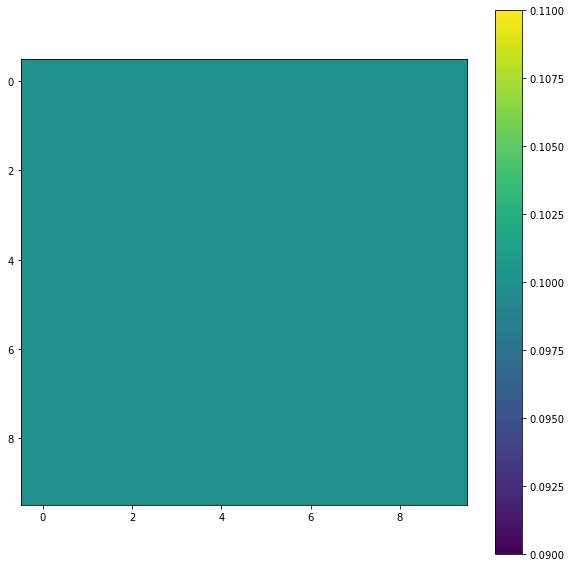

In [3]:
weights = net.units[X[0]].buffer[1:,-1]
d_fig = plt.figure(figsize=(10,10))
d_ax = plt.subplot(1,1,1)
cs = d_ax.imshow(weights.reshape(10,10))
d_fig.colorbar(cs)
plt.show()

In [4]:
net.plants[P].mu = 1.
for i in [0,1]:
    for syn in net.syns[C[i]]:
        if syn.type == 'rga_21':
            syn.lrate = 50.
            syn.alpha = syn.lrate * net.min_delay
            

In [23]:
# Setting X configuration
net.units[X[0]].switch = False # stop switching
# net.units[X[0]].thresh = 0.
# net.units[X[0]].normalize = True
# net.units[V[0]].normalize = True
#net.units[V[0]].alpha = 0.1 * net.min_delay # decrease L__V learning rate

In [4]:
# Setting, fixing controller weights
# standard values:
# A__M_mat = np.rray([[0.27141863, 0.29511766, 0.23279135, 0.20067437],
#                     [0.23307357, 0.1957229 , 0.28739239, 0.28380952]])

# M__C_mat = np.array([[0.0295056,  2.05108517],
#                      [2.05111951, 0.02950648]])
# limit values:
# A__M_mat = np.array([[0.4, .5, 0.08, 0.018],
#                     [0.05, 0. , 0.4, 0.5]])

A__M_mat = np.array([[0.4, 0.1],
                    [0.1, 0.4]])

M__C_mat = np.array([[0.,  2.15],
                     [2.15, 0.]])


for m_idx, m_id in enumerate(M):
    for c_idx, c_id in enumerate(C):
        syn_list = net.syns[c_id]
        for syn in syn_list:
            if syn.preID == m_id:
                syn.w = M__C_mat[c_idx, m_idx]
                syn.alpha = 1e-4 # slowing down learning
                break

for a_idx, a_id in enumerate([A[1], A[3]]):
    for m_idx, m_id in enumerate(M):
        syn_list = net.syns[m_id]
        for syn in syn_list:
            if syn.preID == a_id:
                syn.w = A__M_mat[m_idx, a_idx]
                syn.alpha = 1e-4 # slowing down learning
                break
                

In [5]:
sim_time = 200.
#ratio = 3. # shiva
ratio = 1.9 # breaker
secs2finish = sim_time * ratio
lt1 = time.localtime()
hrs, hrs_rem = divmod(secs2finish, 3600)
mins, mns_rem = divmod(hrs_rem, 60)
xtra_hrs, new_mins = divmod(lt1.tm_min+mins, 60)
print("Expecting to finish at: %d:%d (%d seconds)" % 
      (lt1.tm_hour+hrs+xtra_hrs, new_mins, secs2finish))
start_time = time.time()

times, data, plant_data  = net.run(sim_time)

print('Execution time is %s seconds' % (time.time() - start_time))
lt2 = time.localtime
print("Finished at " + time.strftime('%H:%M'))
data = np.array(data)

# import cProfile
# import pstats
# cProfile.run('times, data, plant_data = net.run(2.)', 'restats')
# prof = pstats.Stats('restats')
# prof.sort_stats('cumulative').print_stats(30)
# data = np.array(data

Expecting to finish at: 11:15 (380 seconds)
Execution time is 325.7300748825073 seconds
Finished at 11:14


MPLEX Error : 0.15452574345880726
Mean reward: 0.5906149292578913


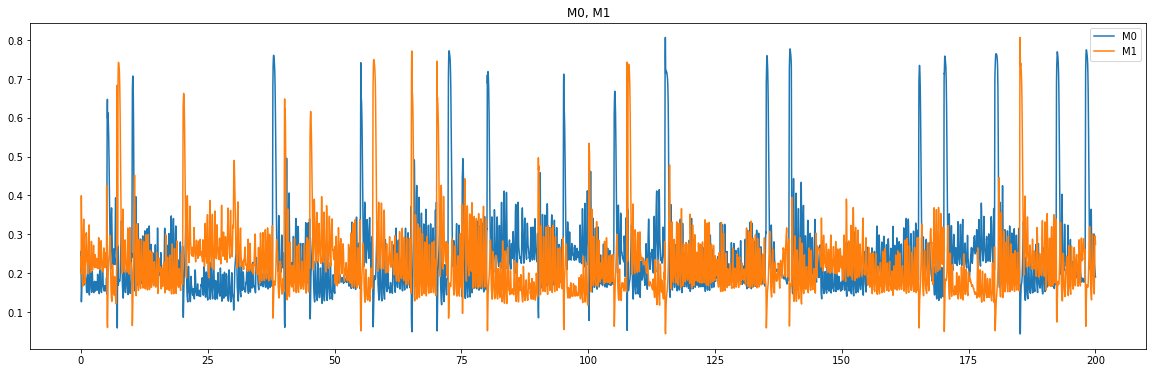

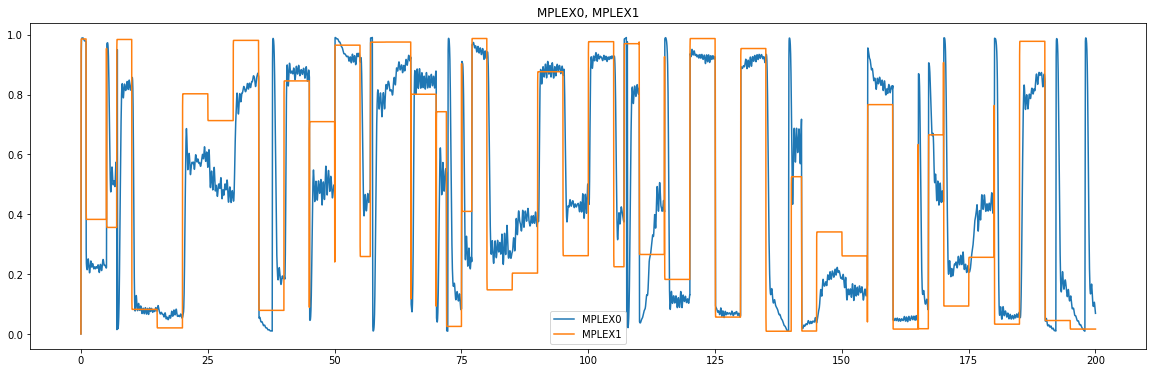

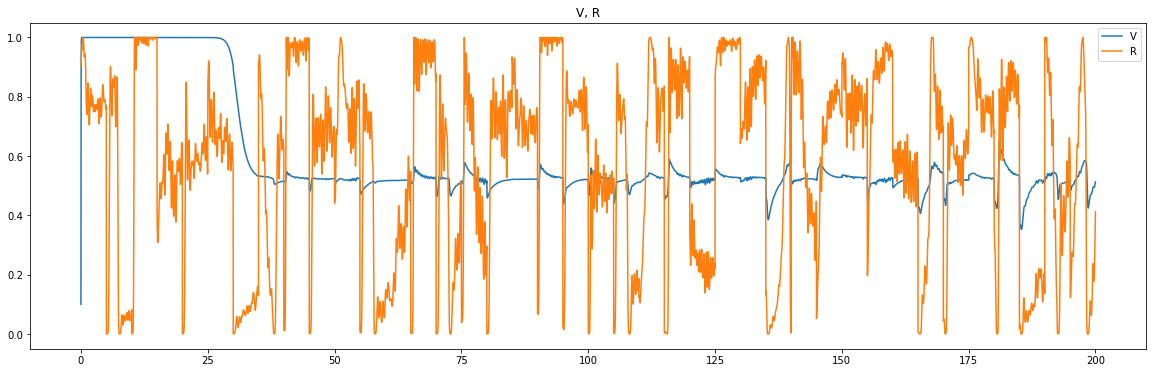

In [6]:
fs = (20,6)

# M
M_fig = plt.figure(figsize=fs)
M_data = np.array(data[M])
plt.plot(times, M_data.transpose())
plt.legend(['M0', 'M1'])
plt.title('M0, M1')
#print(M_data[:,-1])

# MPLEX
MPLEX_fig = plt.figure(figsize=fs)
MPLEX_data = np.array(data[MPLEX])
plt.plot(times, MPLEX_data.transpose())
plt.legend(['MPLEX0', 'MPLEX1'])
plt.title('MPLEX0, MPLEX1')

init_idx = 0 #int((0.5*sim_time)/net.min_delay) # index for last half
MPLEX_error = np.abs(MPLEX_data[0,init_idx:]-MPLEX_data[1,init_idx:]).sum() / (times.size-init_idx)
print("MPLEX Error : " + str(MPLEX_error))

# V, R
V_fig = plt.figure(figsize=fs)
V_data = np.array(data[V])
R_data = np.array(data[R])
#R = np.exp(-net.units[V[0]].R_wid * np.abs(MPLEX_data[0,:]-MPLEX_data[1,:]))
plt.plot(times, V_data.transpose())
plt.plot(times, R_data.transpose())
plt.title('V, R')
#plt.plot(times, R, linewidth=4)
plt.legend(['V', 'R'])

print("Mean reward: " + str(np.mean(R_data)))

plt.show()

MPLEX error: .134, mean_R: .556, desa_error: .877 with X=0, pres_interv=4, mu=1, t=0 to t=500  
MPLEX error: .135, mean_R: .577, desa_error: 835 with X=0, pres_interv=4, mu=1, t=0 to t=500  

MPLEX error: .155, mean_R: .574, desa_error: 1.3 with X=1, pres_interv=4, mu=1, t=0 to t=500  
MPLEX error: .149, mean_R: .591, desa_error: 1.14 with X=1, pres_interv=4, mu=1, t=0 to t=500  


MPLEX error: .152, mean_R= .64,  desa_error: 1.07 with double diag L__X, pres_interv=4, mu=1, t=0 to t=500  
MPLEX error: .145, mean_R= .656,  desa_error: .95 with double diag L__X, pres_interv=4, mu=1, t=0 to t=500  

Currently testing the evolution of double diagonal L__X weights after 500+1000 seconds of simulation...  
double diagonal was stable.

---
Currently running from scratch with pres_interv=5, double learning rates. Ran for 2000 seconds with switchig, 4000 seconds no switching. The learned X configuration did not increase the mean reward, it seems.

---
Testing the mean reward using the manually produced L__X weights:  
MPLEX error: .161, mean_R = .649,  desa_error: .91 with diamond L__X, pres_interv=4, mu=1, t=0 to t=500  
MPLEX error: .15, mean_R = .615,  desa_error: 1.04 with diamond L__X, pres_interv=4, mu=1, t=500 to t=1000  
MPLEX error: .144, mean_R = .631,  desa_error: 1.04 with diamond L__X, pres_interv=4, mu=1, t=1000 to t=1500  
MPLEX error: .138, mean_R = .65,  desa_error: .917 with diamond L__X, pres_interv=4, mu=1, t=1500 to t=2000  
MPLEX error: .125, mean_R = .608,  desa_error: .89 with diamond L__X, pres_interv=4, mu=1, t=2000 to t=2500  
MPLEX error: .15, mean_R = .524,  desa_error: .9 with diamond L__X, pres_interv=4, mu=1, t=2500 to t=3000  
MPLEX error: .152, mean_R = .486,  desa_error: 1.13 with diamond L__X, pres_interv=4, mu=1, t=3000 to t=3500  
MPLEX error: .136, mean_R = .544,  desa_error: 1.104 with diamond L__X, pres_interv=4, mu=1, t=3500 to t=4000  

---
Running with initial diagonal L__V weights, low L__V learning rate, high L__X learning rate, x not switching, balanced L__X weights

---
Running from scratch with pres_interv=5, V_params['L_wid'] =.7 * No2 / np.pi, (from .5*No2/np.pi), x switching for 2000 seconds...  
* mean R=.66 t=0 to t=2000
* mean R=.67 t=2000 to t=4000 (still switching)
* mean R=.664 t=4000 to t=4500 (not switching)
* mean R=.689 t=4500 to t=5000 (not switching)
* mean R=.57 t=5000 to t=5500 (not switching)
* mean R=.57 t=5500 to t=6000 (not switching)

---
Running from scratch, pres_interv=5, mu=1., **g=1.**, x_netB...
* mean R=.57 from t=0 to t=2000 (switching)
* mean R=.73 from t=2000 to t=2500 (not switching)

---
Running from scratch, pres_interv=5, mu=1., **g=9.81, inp_gain=3.**, x_netB...
* mean R=.49 from t=300 to t=2000 (switching)
* mean R=.54 from t=2000 to t=2500 (not switching)
* mean R=.55 from t=4000 to t=6000 (not switching)

---
Running from scratch, pres_interv=5, mu=1., **g=9.81, inp_gain=4.**, x_netB...
* mean R=.58 from t=0 to t=2500 (switching)
* mean R=.69 from t=2500 to t=3000 (not switching)


In [20]:
print(pres_interv)
print(net.plants[0].mu)

5.0
1.0


mean angle error : 0.9272028760856112


Text(0.5, 1.0, 'SPF')

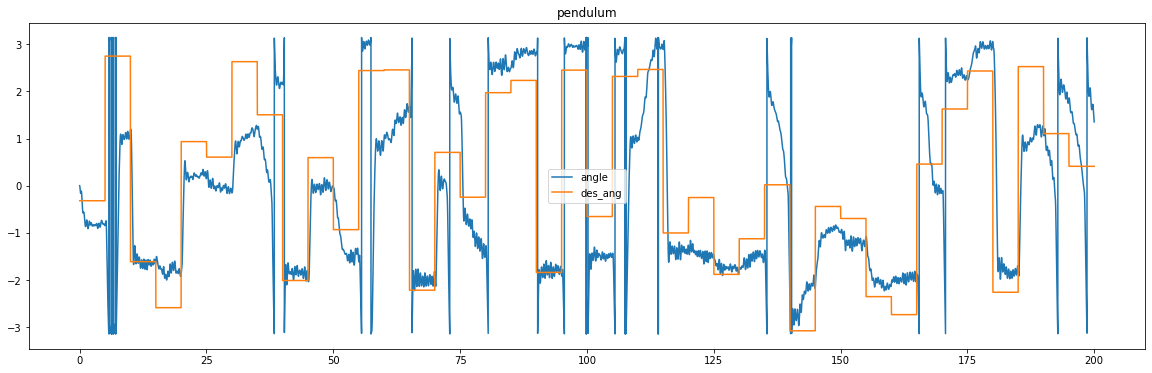

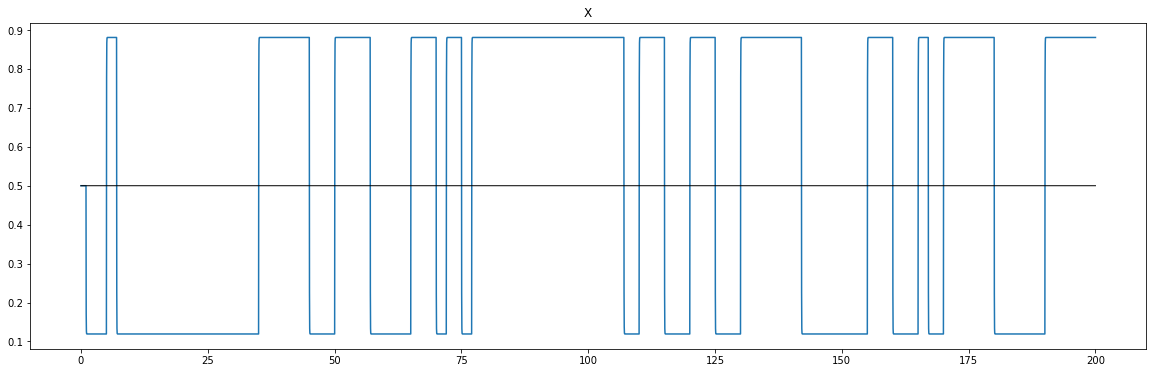

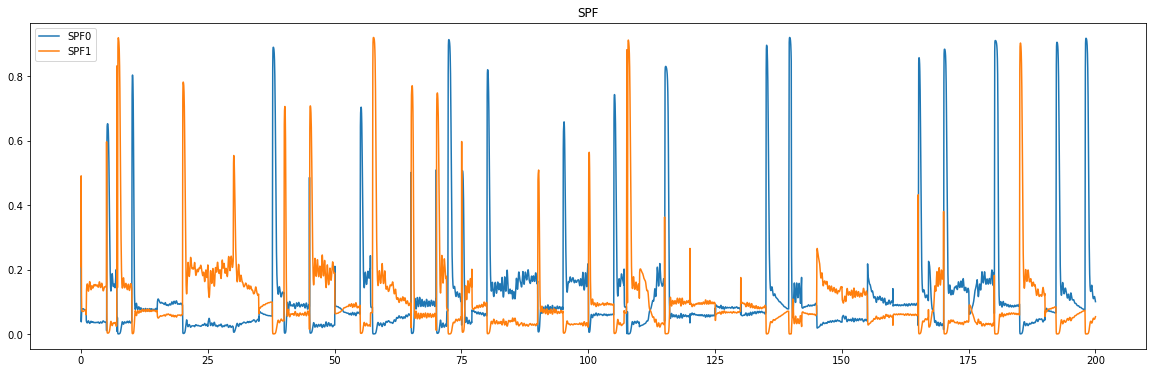

In [7]:
# P, DA
#fs = (40, 10)
P_fig = plt.figure(figsize=fs)
P_data = plant_data[P]
plt.plot(times, P_data[:,0], label='angle')
#plt.plot(times, P_data[:,1], label='ang vel')
desa_data = des_angs[(times/pres_interv).astype(int)]
plt.plot(times, desa_data, label='des_ang')
plt.legend()
plt.title('pendulum')
#print("angle: %f, vel: %f" % (P_data[-1,0],P_data[-1,1]))

init_idx = 0 #int((0.5*sim_time)/net.min_delay) # index for last 200 seconds
ang_error = np.abs(P_data[:,0]-desa_data).sum() / (times.size-init_idx)
print("mean angle error : " + str(ang_error))

# X
X_fig = plt.figure(figsize=fs)
X_data = np.array(data[X])
plt.plot(times, X_data.transpose())
plt.plot(times, 0.5*np.ones(len(times)), 'k', linewidth=1)
#plt.ylim([-0.05,1.05])
#plt.legend(['X'])
plt.title('X')


# SPF
#fs = (20,6)
SPF_fig = plt.figure(figsize=fs)
SPF_data = np.array(data[SPF])
plt.plot(times, SPF_data.transpose())
plt.legend(['SPF0', 'SPF1'])
plt.title('SPF')

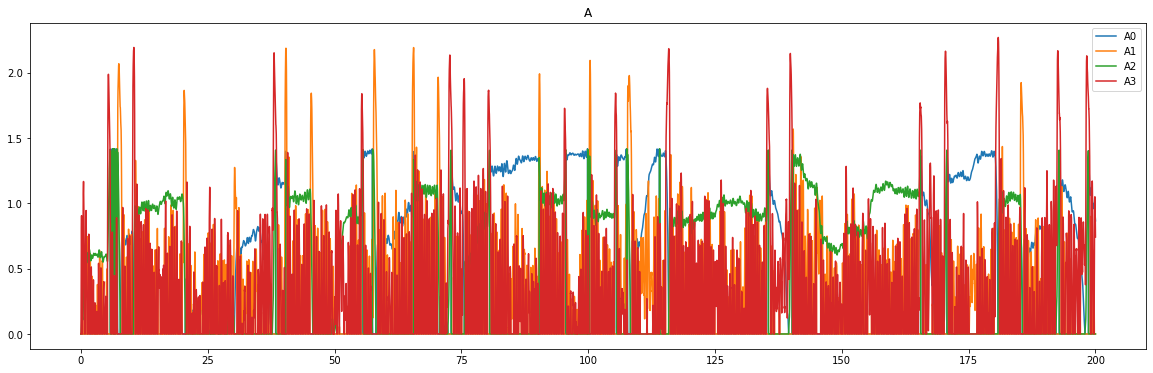

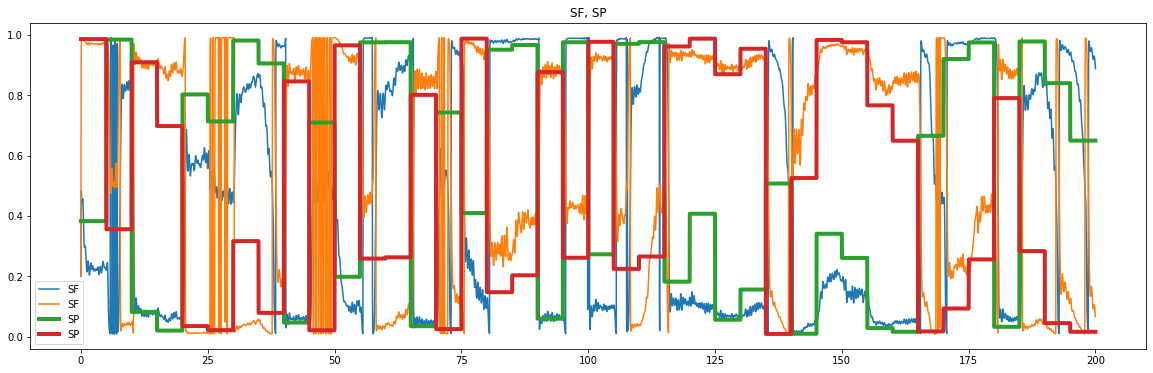

Text(0.5, 1.0, 'A--M0 weights')

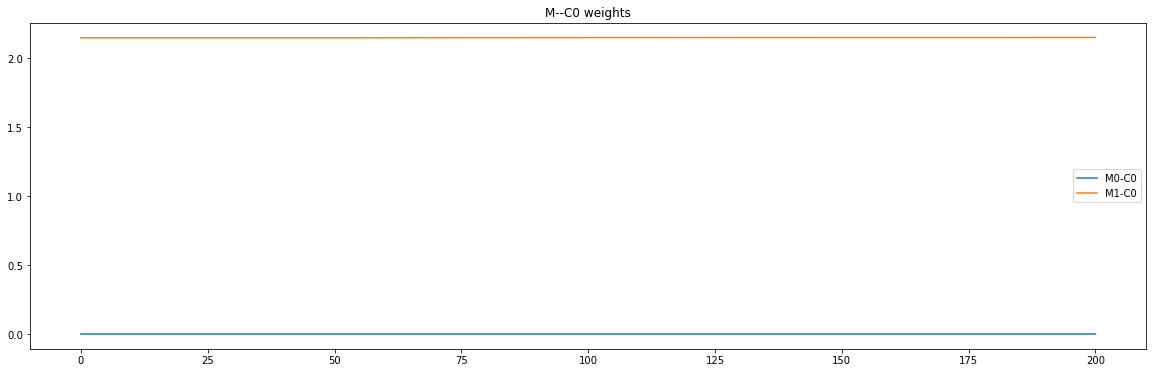

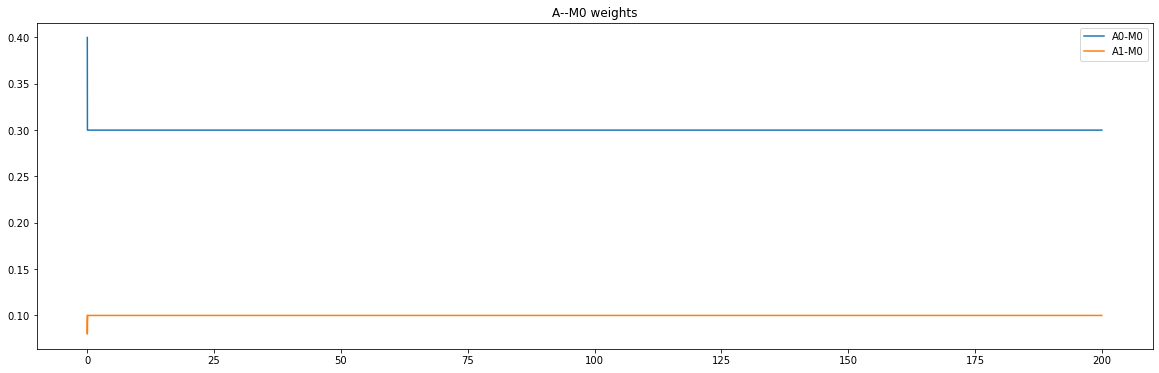

In [8]:
# A
A_fig = plt.figure(figsize=fs)
A_data = np.array(data[A])
plt.plot(times, A_data.transpose())
plt.legend(['A0', 'A1', 'A2', 'A3'])
plt.title('A')
#print(A_data[:,-1])

# L
# L_fig = plt.figure(figsize=fs)
# L_data = np.array(data[L])
# plt.plot(times, L_data.transpose())
# plt.title('L')

# SF, SP
SF_fig = plt.figure(figsize=fs)
SF_data = np.array(data[SF])
SP_data = np.array(data[SP])
plt.plot(times, SF_data.transpose(), label='SF')
plt.plot(times, SP_data.transpose(), label='SP', linewidth=4)
plt.legend()
plt.title('SF, SP')
plt.show()
#print('SF = [%f]' % (SF_data[0,-1]))
#print('SP = [%f]' % (SP_data[0,-1]))


# # C0
# C0_fig = plt.figure(figsize=fs)
# C0_data = np.array(data[C[0]])
# plt.plot(times, C0_data.transpose())
# #plt.plot(times, data[dc_track[0]], linewidth=3)
# plt.title('C0')
# #print(C0_data[-1])

# # C1
# C1_fig = plt.figure(figsize=fs)
# C1_data = np.array(data[C[1]])
# plt.plot(times, C1_data.transpose())
# #plt.plot(times, data[dc_track[1]], linewidth=3)
# plt.title('C1')
# #print(C1_data[-1])

# M--C0 weights
W_fig1 = plt.figure(figsize=fs)
w_track_data = np.array(data[M_C0_track])
plt.plot(times, w_track_data.transpose())
plt.legend(['M0-C0', 'M1-C0'])
plt.title('M--C0 weights')

# A--M0 weights
W_fig2 = plt.figure(figsize=fs)
w_track_data2 = np.array(data[A_M0_track])
plt.plot(times, w_track_data2.transpose())
plt.legend(['A0-M0', 'A1-M0', 'A2-M0', 'A3-M0'])
plt.title('A--M0 weights')


In [9]:
# Testing amount of change in the weights
print("Maximum minus minimum, V:")
print(max(net.units[V[0]].buffer[1:,-1]) - min(net.units[V[0]].buffer[1:,-1]))
print('\n')
print("Maximum minus minimum, X:")
print(max(net.units[X[0]].buffer[1:,-1]) - min(net.units[X[0]].buffer[1:,-1]))

Maximum minus minimum, V:
0.23393741904646864


Maximum minus minimum, X:
0.2273313996993359


In [29]:
net.units[V[0]].buffer[1:,-1]

array([ 0.24670226, -0.02755342, -0.11408069, -0.19717929, -0.35634344,
       -0.42288586, -0.36177612, -0.11373107,  0.2126105 ,  0.38673373,
        0.36143278,  0.23324314,  0.09782357,  0.01720298, -0.20406297,
       -0.37238493, -0.41565796, -0.3798018 , -0.23122711,  0.10997519,
        0.11068423,  0.21523587,  0.1300274 ,  0.15019321,  0.06445544,
       -0.19561118, -0.37546351, -0.41603033, -0.38221467, -0.20261424,
       -0.2054537 , -0.00339777,  0.05694029,  0.20472428,  0.43732303,
        0.25951623, -0.16101581, -0.36479867, -0.41568898, -0.37780381,
       -0.37302631, -0.23365741, -0.12761958,  0.03020781,  0.44763969,
        0.67091452,  0.35808469, -0.05582343, -0.34182946, -0.42586654,
       -0.42493006, -0.3828946 , -0.33601081, -0.26845276,  0.00371713,
        0.54791412,  1.03861455,  0.76577782, -0.03918141, -0.39404091,
       -0.41369302, -0.42701519, -0.42043998, -0.40558022, -0.304674  ,
        0.20489624,  1.40428681,  1.79600879,  0.55324708, -0.27

In [30]:
net.units[X[0]].buffer[1:,-1]

array([-0.61505576, -0.75686916, -0.7584937 , -0.6130615 , -0.3022511 ,
       -0.15848934, -0.34992488, -0.73571604, -0.70830476, -0.52567679,
       -0.62775887, -0.70446412, -0.49074575, -0.32297409, -0.15439124,
        0.04413898,  0.13599712, -0.23414291, -0.37345077, -0.34631166,
       -0.50980839, -0.61675385, -0.22484734, -0.00719764, -0.04337227,
        0.18527728,  0.76917168,  0.67689986,  0.1841668 , -0.09351546,
       -0.06570738,  0.01694225,  0.16145158,  0.09020994,  0.00313185,
        0.19538922,  0.92135111,  1.24363737,  0.64385805,  0.15051773,
        0.29323471,  0.60804652,  0.65163758,  0.35094567,  0.15979328,
        0.28146   ,  1.05444636,  1.55821459,  0.86825369,  0.29703185,
        0.27476918,  0.72873673,  0.92871509,  0.51067096,  0.13063999,
        0.22083868,  0.959324  ,  1.37976633,  0.70355311,  0.20360659,
        0.07401918,  0.41280889,  0.58401201,  0.21975505, -0.17137304,
       -0.1091482 ,  0.31880462,  0.52862126,  0.23492192,  0.00

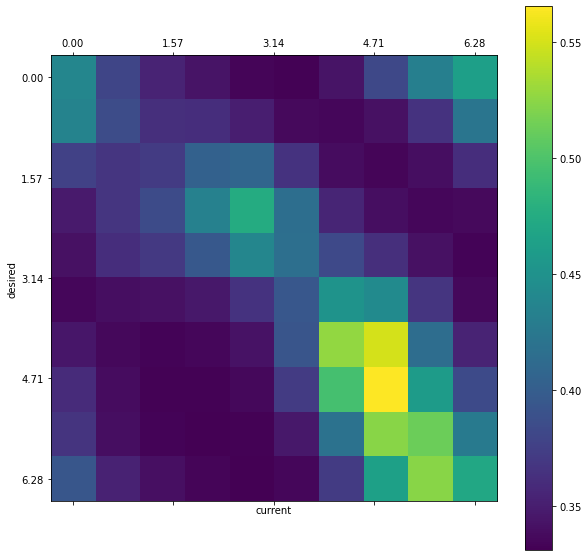

In [10]:
# L__V weights
d_fig = plt.figure(figsize=(10,10))
d_ax = plt.subplot(1,1,1)
cs = d_ax.matshow(net.units[V[0]].buffer[1:,-1].reshape(10,10))
d_fig.colorbar(cs)
d_ax.set_ylabel('desired')
d_ax.set_xlabel('current')
ticks = np.linspace(0.,9,5)
labels = ['{:.2f}'.format(i) for i in np.linspace(0.,2.*np.pi,5)]
d_ax.set_xticks(ticks)
d_ax.set_xticklabels(labels)
d_ax.set_yticks(ticks)
d_ax.set_yticklabels(labels)
plt.show()

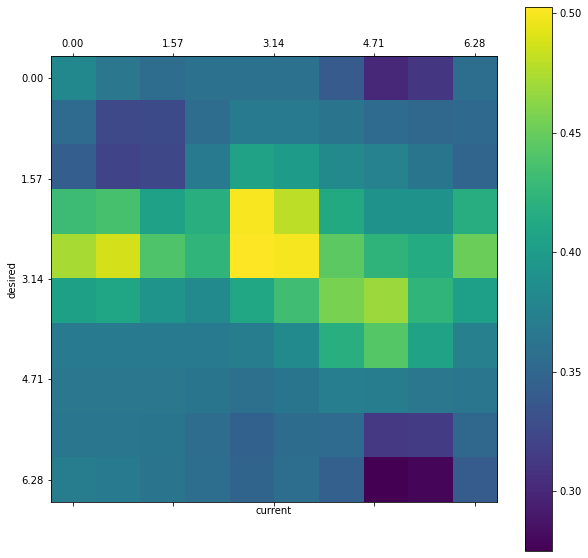

In [11]:
net.units[V[0]].buffer[1:,-1]
d_fig = plt.figure(figsize=(10,10))
d_ax = plt.subplot(1,1,1)
cs = d_ax.matshow(net.units[X[0]].buffer[1:,-1].reshape(10,10))
d_fig.colorbar(cs)
d_ax.set_ylabel('desired')
d_ax.set_xlabel('current')
ticks = np.linspace(0.,9,5)
labels = ['{:.2f}'.format(i) for i in np.linspace(0.,2.*np.pi,5)]
d_ax.set_xticks(ticks)
d_ax.set_xticklabels(labels)
d_ax.set_yticks(ticks)
d_ax.set_yticklabels(labels)
plt.show()

In [33]:
print(np.abs(net.units[X[0]].buffer[1:,-1]).sum())
print(np.abs(net.units[V[0]].buffer[1:,-1]).sum())

40.08887330295561
40.14038105242136


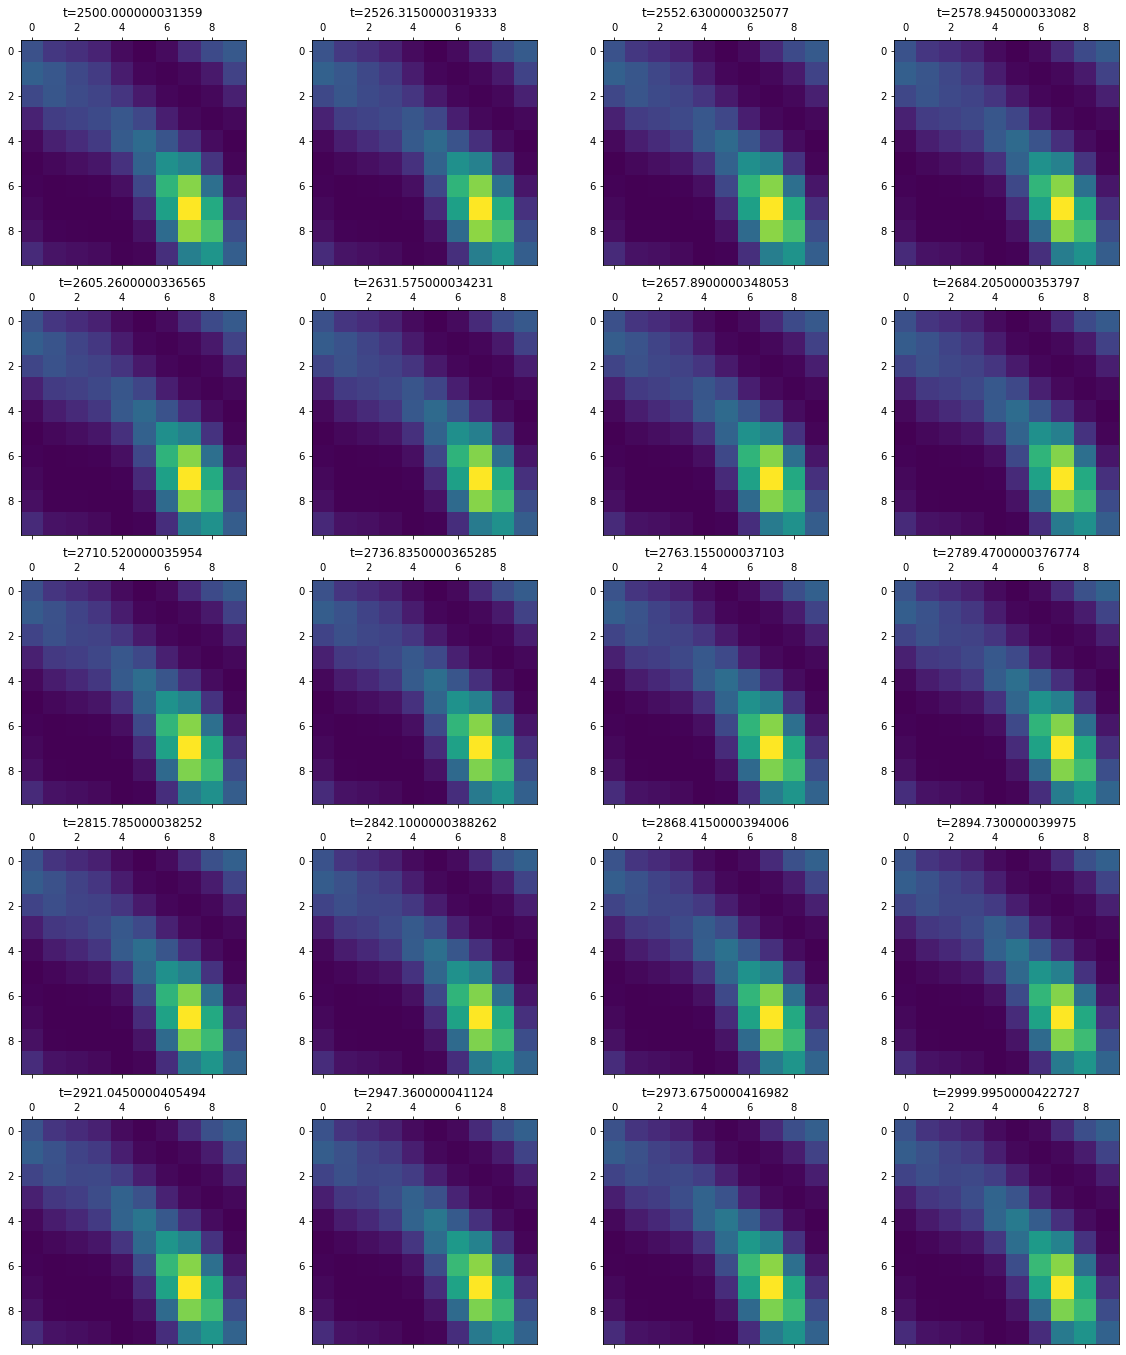

In [34]:
# Visualize L__V weights
n_plots = 20 # number of plots, each at a different time
n_rows = int(np.ceil(np.sqrt(n_plots)))
n_cols = int(np.ceil(n_plots/n_rows))
t_idxs = [int(i) for i in np.linspace(0, len(times)-1, n_plots)]

L__V_fig, L__V_axs = plt.subplots(n_rows, n_cols, figsize=(fs[0], n_cols*fs[1]))
for i_plot in range(n_plots):
    row, col = np.divmod(i_plot, n_cols)
    ax = L__V_axs[row][col]
    cs = ax.matshow(data[v_track][:,t_idxs[i_plot]].reshape(No2,No2))
    ax.set_title('t='+str(times[t_idxs[i_plot]]))
    
plt.show()

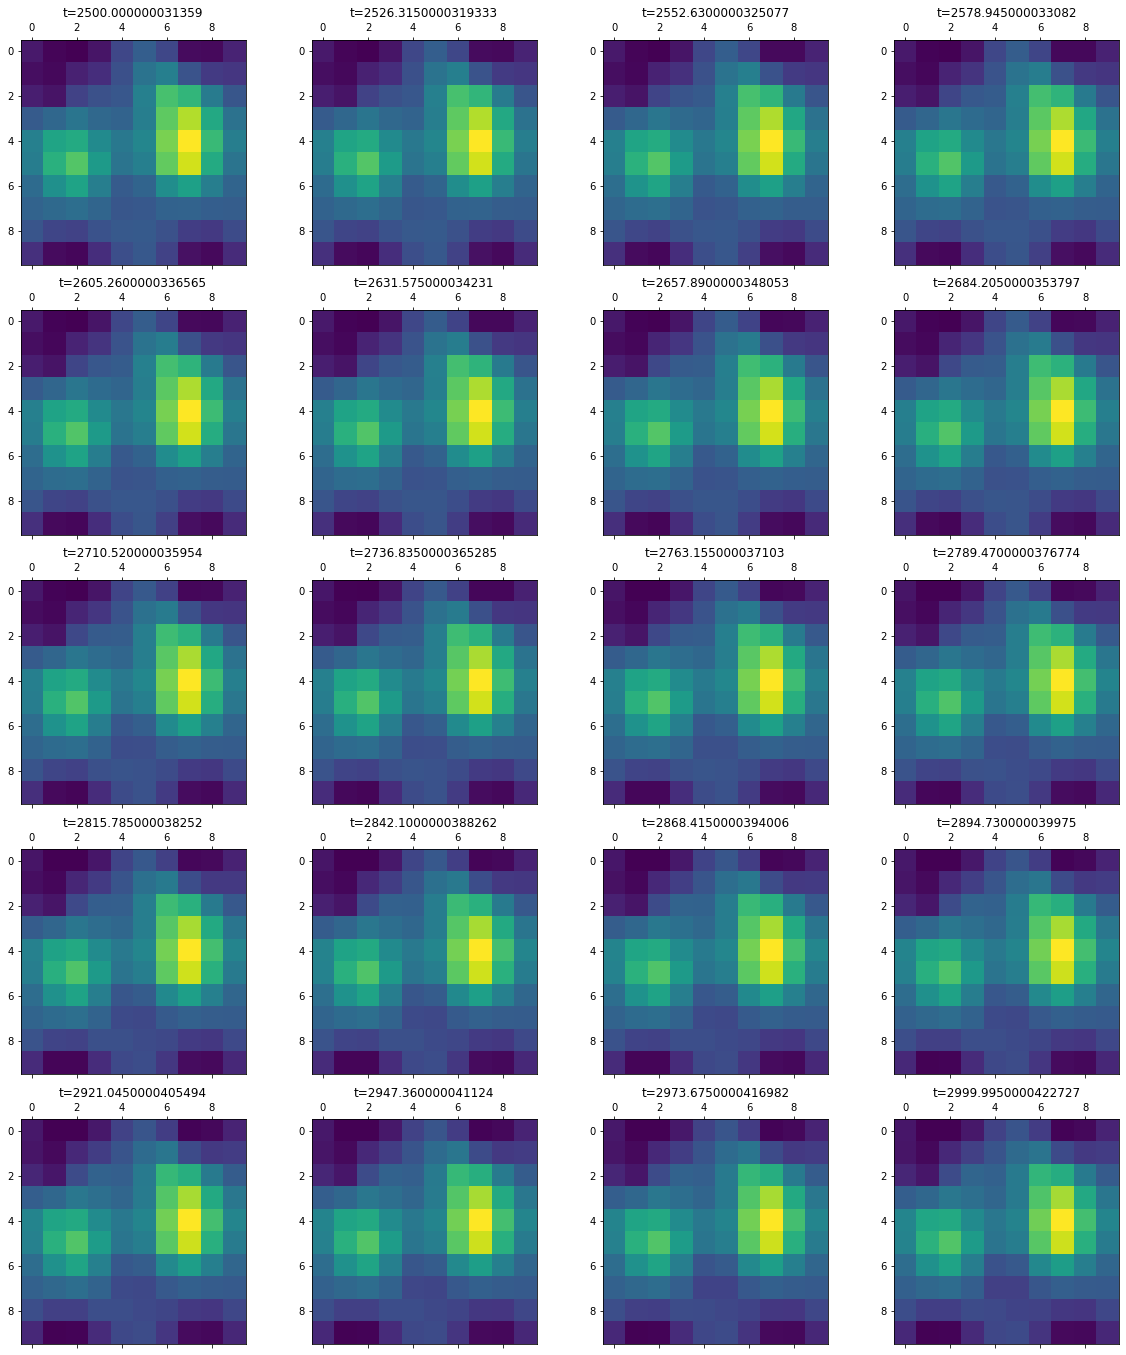

In [35]:
# Visualize L__X weights
n_plots = 20 # number of plots, each at a different time
n_rows = int(np.ceil(np.sqrt(n_plots)))
n_cols = int(np.ceil(n_plots/n_rows))
t_idxs = [int(i) for i in np.linspace(0, len(times)-1, n_plots)]

L__X_fig, L__X_axs = plt.subplots(n_rows, n_cols, figsize=(fs[0], n_cols*fs[1]))
for i_plot in range(n_plots):
    row, col = np.divmod(i_plot, n_cols)
    ax = L__X_axs[row][col]
    cs = ax.matshow(data[x_track][:,t_idxs[i_plot]].reshape(No2,No2))
    ax.set_title('t='+str(times[t_idxs[i_plot]]))
    
plt.show()

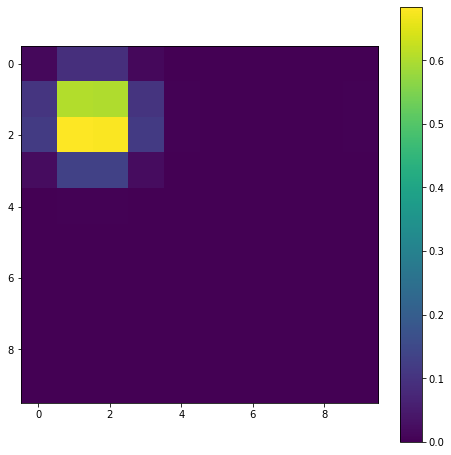

In [76]:
L_out_fig = plt.figure(figsize=(8,8))
axs = plt.subplot(1,1,1)
cs = axs.imshow(net.units[V[0]].L_out_copy.reshape(10,10))
L_out_fig.colorbar(cs)
plt.show()

In [48]:
net.units[V[0]].L_out_copy.sum()

3.5716123740244305

In [18]:
net.units[SP[0]].set_function(lambda t: des_sf[int(round(t/15.))])

In [34]:
# reducing the scope of the plots
data_back = data
times_back = times
plant_data_back = [np.array([])]
plant_data_back[0] = plant_data[0]

first_idx=500*200
second_idx=600*200
times = times[first_idx:second_idx]
data = data[:, first_idx:second_idx]
plant_data[0] = plant_data[0][first_idx:second_idx,:]

In [10]:
# recover the data
data = data_back
plant_data[0] = plant_data_back[0]
times = times_back

In [21]:
# Storing the M__C and A__M connections
M__C_mat = np.zeros((2,2)) # rows are target (C) neurons
for m_idx, m_id in enumerate(M):
    for c_idx, c_id in enumerate(C):
        syn_list = net.syns[c_id]
        for syn in syn_list:
            if syn.preID == m_id:
                M__C_mat[c_idx, m_idx] = syn.w
                break
                
A__M_mat = np.zeros((2,4)) # rows are target (M) neurons
for a_idx, a_id in enumerate(A):
    for m_idx, m_id in enumerate(M):
        syn_list = net.syns[m_id]
        for syn in syn_list:
            if syn.preID == a_id:
                A__M_mat[m_idx, a_idx] = syn.w
                break
print(M__C_mat)
print(A__M_mat)

[[1.68646211e-07 2.08082448e+00]
 [2.08121483e+00 1.56862359e-07]]
[[0.34878441 0.25118419 0.16842648 0.13160544]
 [0.12283056 0.08501225 0.43893599 0.25322015]]


In [7]:
plotty = plotter(net, times, data)

In [12]:
plotty.act_anim(S1+S2+L+R+V, 0.5, interv=10, slider=False)

In [8]:
plotty.conn_anim(L, V)

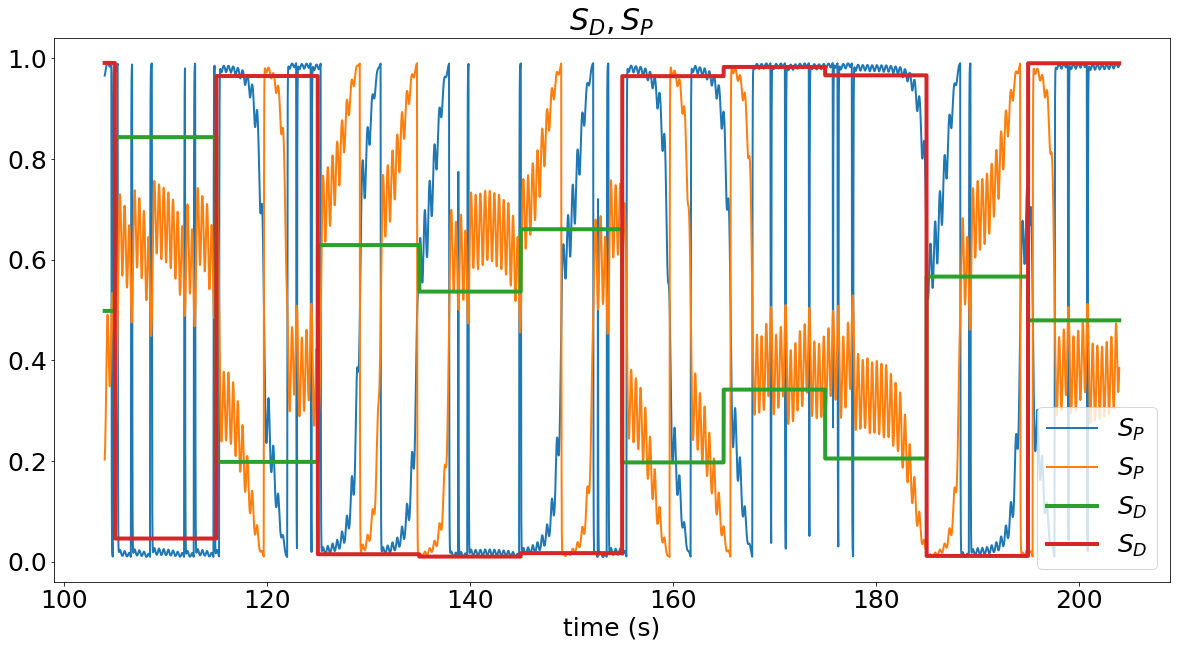

In [18]:
# A figure with more formatting
SPF_fig = plt.figure(figsize=(20,10))
SF_data = np.array(data[SF])
SP_data = np.array(data[SP])
plt.plot(times, SF_data.transpose(), label='$S_P$', linewidth=2)
plt.plot(times, SP_data.transpose(), label='$S_D$', linewidth=4)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.legend(fontsize=25)
plt.xlabel('time (s)', fontsize =25)
plt.title('$S_D, S_P$', fontsize=30)
plt.show()

In [4]:
# good initial weights

# M__C
# M[0] has the F-D error, so you want C[0] (which exerts positive torque)
# to be driven by M[1] instead, and C[1] to be driven by M[0]
shift = 0
while not net.syns[C[0]][shift].type is synapse_types.rga:
    shift += 1
net.syns[C[0]][shift].w = 0.1
net.syns[C[0]][shift+1].w = 0.8 # C[0] driven by M[1]
net.syns[C[1]][shift].w = 0.8
net.syns[C[1]][shift+1].w = 0.1

# L__X, L__V
scale = 1. # maximum weight value
def dist(c1, c2):
    """ Periodic distance between 2-dim coordinates c1 and c2. 

        Assumes c1 and c2 are inside the box with corners [-0.5, -0.5], [0.5, 0.5].
    """
    x_dist = min(max(c1[0], c2[0]) - min(c1[0], c2[0]),  # "inner" distance
                 0.5-max(c1[0], c2[0]) + (min(c1[0], c2[0])+0.5) ) # "outer" distance
    y_dist = min(max(c1[1], c2[1]) - min(c1[1], c2[1]),  # "inner" distance
                 0.5-max(c1[1], c2[1]) + (min(c1[1], c2[1])+0.5) ) # "outer" distance
    return np.sqrt(x_dist*x_dist + y_dist*y_dist)

#L__V_iw = np.zeros((No2, No2))
j = 0
for i in range(len(L)):  # Setting L__V weights
    u = net.units[L[i]]
    c = u.coordinates
    d = dist(c, [c[1], c[1]])
    Vsyn = net.syns[V[0]][i]
    Xsyn = net.syns[X[0]][i+j]
    while Xsyn.type != synapse_types.diff_rm_hebbian:
        j +=1
        Xsyn = net.syns[X[0]][i+j]
    if Vsyn.preID == u.ID and Xsyn.preID == u.ID:
        a, b = divmod(i, No2)
        Vsyn.w = scale*(.5 - d)
        Xsyn.w = 0.01 if abs(c[1]-c[0]) < 0.5-max(c[1],c[0]) + min(c[1],c[0])+0.5 else .8
    else:
        print("FAILED!!!!!!!")

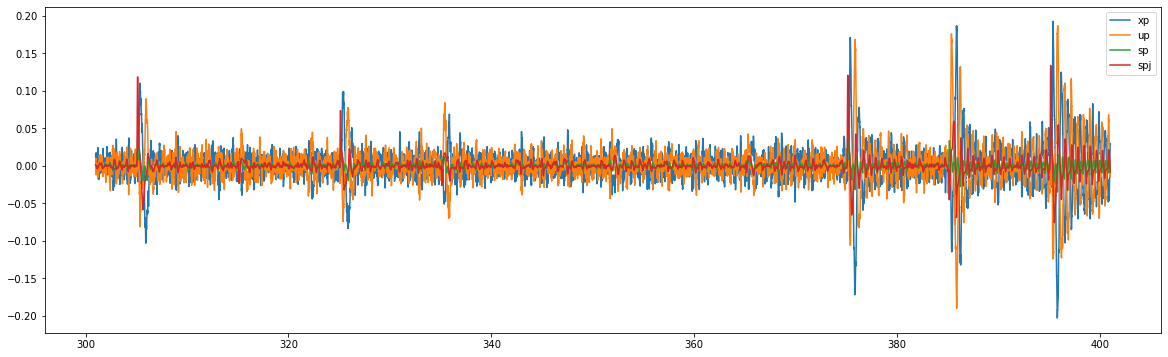

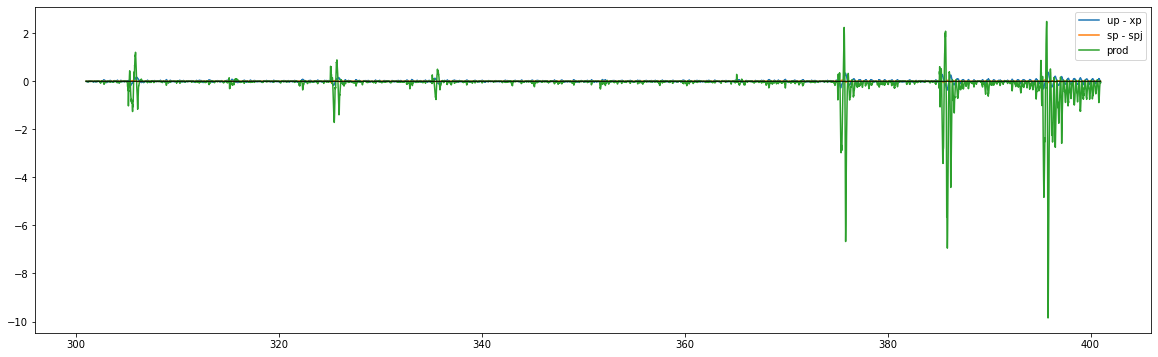

In [20]:
# plot all factors in the M--C0 synaptic plasticity
fs = (20,6)
plastic_fig = plt.figure(figsize=fs)
xp_data = np.array(data[xp_track[0]])
up_data = np.array(data[up_track[0]])
sp_data = np.array(data[sp_track[0]])
spj_data = np.array(data[spj_track[0]])
plt.plot(times, xp_data)
plt.plot(times, up_data)
plt.plot(times, sp_data)
plt.plot(times, spj_data)
plt.legend(['xp', 'up', 'sp', 'spj'])

plastic_fig2 = plt.figure(figsize=fs)
f1 = up_data - xp_data
f2 = sp_data - spj_data
rule = 500. * f1 * f2
plt.plot(times, f1)
plt.plot(times, f2)
plt.plot(times, rule)
plt.plot(times, np.zeros(len(times)), 'k', linewidth=1)
plt.legend(['up - xp', 'sp - spj', 'prod'])
plt.show()

In [11]:
# checking some connections
print("Connections to M0 unit")
for idx, syn in enumerate(net.syns[M[0]]):
    pre_id = syn.preID
    pre_type = net.units[pre_id].type
    if pre_id == P and hasattr(syn, 'plant_out'):
        pre_pop = 'P'
    elif pre_id in A:
        pre_pop = 'A'
    #elif pre_id in L:
    #    pre_pop = 'L'
    elif pre_id in M:
        pre_pop = 'M'
    #elif pre_id in V:
    #    pre_pop = 'V'
    elif pre_id in SPF:
        pre_pop = 'SPF'
    else:
        pre_pop = 'erroneous'
    if pre_pop == 'P':
        plant_out = str(syn.plant_out)
    else:
        plant_out = 'None'
    print('%d) %s (%d) --> M0, w=%f, port=%d, plant_out=%s'%(idx, pre_pop, pre_id, syn.w, syn.port, plant_out))

print("Connections to M1 unit")
for idx, syn in enumerate(net.syns[M[1]]):
    pre_id = syn.preID
    pre_type = net.units[pre_id].type
    if pre_id == P and hasattr(syn, 'plant_out'):
        pre_pop = 'P'
    elif pre_id in A:
        pre_pop = 'A'
    #elif pre_id in L:
    #    pre_pop = 'L'
    elif pre_id in M:
        pre_pop = 'M'
    #elif pre_id in V:
    #    pre_pop = 'V'
    elif pre_id in SPF:
        pre_pop = 'SPF'
    else:
        pre_pop = 'erroneous'
    if pre_pop == 'P':
        plant_out = str(syn.plant_out)
    else:
        plant_out = 'None'
    print('%d) %s (%d) --> M1, w=%f, port=%d, plant_out=%s'%(idx, pre_pop, pre_id, syn.w, syn.port, plant_out))
    
print("Connections to C0 unit")
for idx, syn in enumerate(net.syns[C[0]]):
    pre_id = syn.preID
    pre_type = net.units[pre_id].type
    if pre_id == P and hasattr(syn, 'plant_out'):
        pre_pop = 'P'
    elif pre_id in A:
        pre_pop = 'A'
    elif pre_id in M:
        pre_pop = 'M'
    elif pre_id in C:
        pre_pop = 'C'
    else:
        pre_pop = 'erroneous'
    if pre_pop == 'P':
        plant_out = str(syn.plant_out)
    else:
        plant_out = 'None'
    print('%d) %s (%d) --> C0, w=%f, port=%d, plant_out=%s'%(idx, pre_pop, pre_id, syn.w, syn.port, plant_out))  

print("Connections to C1 unit")
for idx, syn in enumerate(net.syns[C[1]]):
    pre_id = syn.preID
    pre_type = net.units[pre_id].type
    if pre_id == P and hasattr(syn, 'plant_out'):
        pre_pop = 'P'
    elif pre_id in A:
        pre_pop = 'A'
    elif pre_id in M:
        pre_pop = 'M'
    elif pre_id in C:
        pre_pop = 'C'
    else:
        pre_pop = 'erroneous'
    if pre_pop == 'P':
        plant_out = str(syn.plant_out)
    else:
        plant_out = 'None'
    print('%d) %s (%d) --> C1, w=%f, port=%d, plant_out=%s'%(idx, pre_pop, pre_id, syn.w, syn.port, plant_out))  

    
print("Connections to afferent units")
for idx, syn in enumerate(net.syns[A[2]]):
    pre_id = syn.preID
    pre_type = net.units[pre_id].type
    if pre_id == P and hasattr(syn, 'plant_out'):
        pre_pop = 'P'
    elif pre_id in A:
        pre_pop = 'A'
    else:
        pre_pop = 'erroneous'
    if pre_pop == 'P':
        plant_out = str(syn.plant_out)
    else:
        plant_out = 'None'
    print('%d) %s (%d) --> A, w=%f, port=%d, plant_out=%s'%(idx, pre_pop, pre_id, syn.w, syn.port, plant_out))

print("Connections to plant")
for idx, syn in enumerate(net.plants[P].inp_syns[0]):
    pre_id = syn.preID
    pre_type = net.units[pre_id].type
    if pre_id in C:
        pre_pop = 'C'
    else:
        pre_pop = 'erroneous'
    print('%d) %s (%d, %s) --> P, w=%f'%(idx, pre_pop, pre_id, pre_type, syn.w))
    
print("Connections to MPLEX units")
for idx, syn in enumerate(net.syns[MPLEX[0]]):
    pre_id = syn.preID
    pre_type = net.units[pre_id].type
    if pre_id in X:
        pre_pop = 'X'
    elif pre_id in SF:
        pre_pop = 'SF'
    elif pre_id in SP:
        pre_pop = 'SP'
    else:
        pre_pop = 'erroneous'
    print('%d) %s (%d) --> MPLEX, w=%f, port=%d'%(idx, pre_pop, pre_id, syn.w, syn.port))  

print("Connections to SF units")
for idx, syn in enumerate(net.syns[SF[1]]):
    pre_id = syn.preID
    pre_type = net.units[pre_id].type
    if pre_id == P and hasattr(syn, 'plant_out'):
        pre_pop = 'P'
    elif pre_id in T:
        pre_pop = 'T'
    else:
        pre_pop = 'erroneous'
    print('%d) %s (%d) --> SF, w=%f, port=%d, plant_out=%s'%
          (idx, pre_pop, pre_id, syn.w, syn.port, plant_out))

print("Connections to X unit")
for idx, syn in enumerate(net.syns[X[0]]):
    pre_id = syn.preID
    pre_type = net.units[pre_id].type
    if pre_id in V:
        pre_pop = 'V'
    elif pre_id in MPLEX:
        pre_pop = 'MPLEX'
    else:
        pre_pop = 'erroneous'
    print('%d) %s (%d) --> X, w=%f, port=%d'%(idx, pre_pop, pre_id, syn.w, syn.port))  
    
print("Connections to V unit")
for idx, syn in enumerate(net.syns[V[0]]):
    pre_id = syn.preID
    pre_type = net.units[pre_id].type
    if pre_id in MPLEX:
        pre_pop = 'MPLEX'
    elif pre_id in R:
        pre_pop = 'R'
    else:
        pre_pop = 'erroneous'
    print('%d) %s (%d) --> V, w=%f, port=%d'%(idx, pre_pop, pre_id, syn.w, syn.port))  


Connections to M0 unit
0) A (0) --> M0, w=0.219605, port=2, plant_out=None
1) A (1) --> M0, w=0.248533, port=2, plant_out=None
2) A (2) --> M0, w=0.224219, port=2, plant_out=None
3) A (3) --> M0, w=0.207640, port=2, plant_out=None
4) M (107) --> M0, w=-1.000000, port=3, plant_out=None
5) SPF (155) --> M0, w=1.000000, port=1, plant_out=None
Connections to M1 unit
0) A (0) --> M1, w=0.252435, port=2, plant_out=None
1) A (1) --> M1, w=0.167266, port=2, plant_out=None
2) A (2) --> M1, w=0.215700, port=2, plant_out=None
3) A (3) --> M1, w=0.264603, port=2, plant_out=None
4) M (106) --> M1, w=-1.000000, port=3, plant_out=None
5) SPF (156) --> M1, w=1.000000, port=1, plant_out=None
Connections to C0 unit
0) C (5) --> C0, w=-1.500000, port=1, plant_out=None
1) M (106) --> C0, w=0.014658, port=0, plant_out=None
2) M (107) --> C0, w=2.066072, port=0, plant_out=None
Connections to C1 unit
0) C (4) --> C1, w=-1.500000, port=1, plant_out=None
1) M (106) --> C1, w=2.066016, port=0, plant_out=None
2)

In [23]:
# running in two stages. Initial high learning rate and viscosity.
sim_time = 150.
#ratio = 15.1 # cns-amd
#ratio = 20. # breaker
ratio = 1.6 # breaker, no L,V
secs2finish = sim_time * ratio
lt1 = time.localtime()
hrs, hrs_rem = divmod(secs2finish, 3600)
mins, mns_rem = divmod(hrs_rem, 60)
xtra_hrs, new_mins = divmod(lt1.tm_min+mins, 60)
print("Expecting to finish firstst simulation at %d:%d (%d seconds)" % 
      (lt1.tm_hour+hrs+xtra_hrs, new_mins, secs2finish))
start_time = time.time()

times, data, plant_data  = net.run(sim_time)

print('Initial execution time is %s seconds' % (time.time() - start_time))
lt2 = time.localtime
print("Finished at " + time.strftime('%H:%M'))
data = np.array(data)

sim_time = 100.
net.plants[0].mu = 0.5
for i in [0,1]:
    for syn in net.syns[C[i]]:
        if syn.type == 'rga_21':
            syn.lrate = 100.
            syn.alpha = syn.lrate * net.min_delay

secs2finish = sim_time * ratio
lt1 = time.localtime()
hrs, hrs_rem = divmod(secs2finish, 3600)
mins, mns_rem = divmod(hrs_rem, 60)
xtra_hrs, new_mins = divmod(lt1.tm_min+mins, 60)
print("Expecting to finish at: %d:%d (%d seconds)" % 
      (lt1.tm_hour+hrs+xtra_hrs, new_mins, secs2finish))
start_time = time.time()

times, data, plant_data  = net.run(sim_time)

print('Second execution time is %s seconds' % (time.time() - start_time))
lt2 = time.localtime
print("Finished at " + time.strftime('%H:%M'))
data = np.array(data)

Expecting to finish firstst simulation at 17:23 (240 seconds)


KeyboardInterrupt: 

---